### LightGBM のチカラを見せてやろ

In [11]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import cross_validation

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# Function for Measure Performance# 
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [12]:
#載入資料
train=pd.read_csv('train.csv',encoding='utf-8')
test=pd.read_csv('test_public.csv',encoding='utf-8')
submit=pd.read_csv('sampleSubmission.csv',encoding='utf-8')

In [17]:
#Data Preparation for LightGBM
import os

# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
application_train, categorical_feats, encoder_dict = label_encoder(train)
X = train.drop(['Class'], axis=1)
y = train.Class

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [37]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(objective = 'binary', learning_rate = 0.05, n_estimators = 100, random_state=0)

param_grid = {
    'num_leaves': [30,35,40,45], #[35,40,45]做完是40
    'feature_fraction': [0.2,0.3,0.4],#做過[0.2,0.3,0.4,0.5]出來是0.4
    #'bagging_fraction': [0.6,0.7,0.8],
    'max_depth':[6,7,8],
    'max_bin':[20],
    #'lambda_l1':[0.3,0.6],#V4開始做lambda_l1
    'lambda_l2':[0.08,0.09,0.10],
    'min_split_gain':[0.04,0.05,0.06],#做過[0.04,0.05,0.06]出來0.06
    'min_child_weight':[7]
}

%time LGBM_grid = GridSearchCV(estimator, param_grid)

Start training...
CPU times: user 617 µs, sys: 312 µs, total: 929 µs
Wall time: 411 µs


In [38]:
import warnings
warnings.filterwarnings("ignore")
%time LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

CPU times: user 54min 28s, sys: 6min 7s, total: 1h 36s
Wall time: 25min 36s
Best parameters found by grid search are: {'feature_fraction': 0.4, 'lambda_l2': 0.09, 'max_bin': 20, 'max_depth': 6, 'min_child_weight': 7, 'min_split_gain': 0.04, 'num_leaves': 30}


In [39]:
# Final Model
evals_result = {} 
print('Start predicting...')
LGBM= lgb.LGBMClassifier(objective = 'binary',
                         learning_rate = 0.05, 
                         n_estimators = 100, 
                         random_state=0,
                         num_leaves = LGBM_grid.best_params_['num_leaves'],
                         feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                         #bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                         max_depth = LGBM_grid.best_params_['max_depth'],
                         max_bin = LGBM_grid.best_params_['max_bin'],
                         #lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                         lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                         min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                         min_child_weight = LGBM_grid.best_params_['min_child_weight'])
%time LGBM_fit = LGBM.fit(X_train, y_train)
print('Predicting is over')

Start predicting...
CPU times: user 3.33 s, sys: 456 ms, total: 3.79 s
Wall time: 1.85 s
Predicting is over


Accuracy:1.000
Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     59707
          1       0.94      0.82      0.87       103

avg / total       1.00      1.00      1.00     59810

Confusion matrix
[[59702     5]
 [   19    84]]
ROC AUC Score
0.9916226830016679
Feature importances: [38, 22, 39, 19, 26, 51, 20, 13, 49, 37, 24, 25, 26, 50, 31, 42, 38, 18, 34, 16, 43, 29, 39, 17, 23, 59, 15, 42, 21, 42, 70]
Plot feature importances...


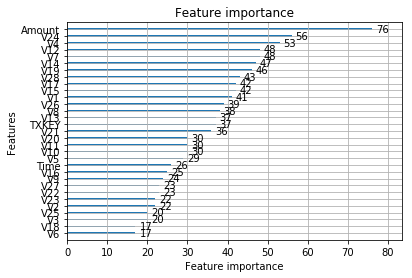

In [42]:
#v2
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_fit, max_num_features=len(train))
plt.show()

Accuracy:1.000
Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     59707
          1       0.94      0.82      0.87       103

avg / total       1.00      1.00      1.00     59810

Confusion matrix
[[59702     5]
 [   19    84]]
ROC AUC Score
0.9916226830016679
Feature importances: [38, 22, 39, 19, 26, 51, 20, 13, 49, 37, 24, 25, 26, 50, 31, 42, 38, 18, 34, 16, 43, 29, 39, 17, 23, 59, 15, 42, 21, 42, 70]
Plot feature importances...


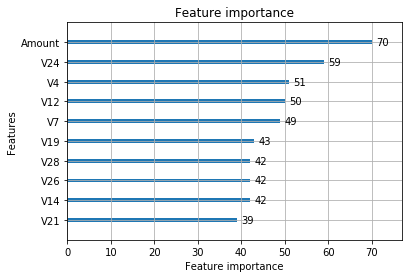

In [27]:
#v1
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_fit, max_num_features=10)
plt.show()

In [31]:
LGBM_pred =LGBM.predict(test)
submit['Class'] = LGBM_pred
submit['Class'] = submit['Class'].astype(int)
submit.to_csv('submit_002.csv', index= False)